# Solving the Quantum Linear Systems Problem (QLSP) using AQC 


**Adiabatic Quantum Computing (AQC)** leverages the adiabatic theorem to solve computational problems by gradually evolving a quantum system from an initial ground state to the ground state of a problem-specific Hamiltonian (see the AQC tutorial). 

This tutorial focuses on applying the AQC approach to solve the **Quantum Linear Systems Problem (QLSP)**, a cornerstone problem in quantum computing with significant applications in fields like machine learning, physics, and optimization.

Specifically, we aim to demonstrate how to utilize AQC to approximate the solution to the QLSP [[1](#QLSP)]. This problem involves finding a quantum state that corresponds to the solution of a linear system of equations. The tutorial provides a structured overview of the QLSP, its mathematical formulation, and the steps needed to transform it into an eigenvalue problem, laying the foundation for solving it within the AQC framework.

*This demonstration follows the [[1](#QLSP)] paper. This notebook was written in collaboration with Prof. Lin Lin and Dr. Dong An, the authors of the paper.*


---


## Problem Statement

Given a Hermitian positive-definite matrix $A$ and a vector $|b\rangle$, the goal is to approximate 
$|x\rangle$—the solution to the linear system $A|x\rangle=|b\rangle$—as a quantum state.


We are given:
- **Matrix** $A \in \mathbb{C}^{N \times N}$, an invertible Hermitian and positive-definite matrix with condition number $\kappa$ and $\|A\|_2 = 1$.
- **Vector** $|b\rangle \in \mathbb{C}^N$, a normalized vector.
- **Target Error** $\epsilon$, specifying the desired accuracy.

The goal is to prepare a quantum state $|x_a\rangle$, which is an $\epsilon$-approximation of the normalized solution $|x\rangle = A^{-1}|b\rangle / \|A^{-1}|b\rangle\|_2$. The approximation satisfies

$$
\| |x_a\rangle \langle x_a| - |x\rangle \langle x| \|_2 \leq \epsilon.
$$


## Transformation into AQC

The QLSP is converted into an equivalent eigenvalue problem to leverage quantum computation. This involves the following steps.

### 1. Constructing $H_0$
Define:

$$
H_0 = \sigma_x \otimes Q_b = 
\begin{bmatrix}
0 & Q_b \\
Q_b & 0
\end{bmatrix},
$$

where $Q_b = I_N - |b\rangle \langle b|$ is a projection operator orthogonal to $|b\rangle$.

Key properties:
- $H_0$ is Hermitian.
- The null space of $H_0$: $\text{Null}(H_0) = \text{span}(|\tilde{b}\rangle, |\bar{b}\rangle)$, where 

$$
|\tilde{b}\rangle = |0, b\rangle = \begin{bmatrix} b \\ 0 \end{bmatrix}, \quad 
|\bar{b}\rangle = |1, b\rangle = \begin{bmatrix} 0 \\ b \end{bmatrix}.
$$


>*The **null space** of a matrix $A$ is the set of all vectors $ \mathbf{x} $ such that*
>
> $A\mathbf{x} = 0.$
>
>*With regards to eigenstates and eigenvalues:*
>- *The null space corresponds to the eigenspace of $A$ associated with the eigenvalue $0$.*
>- *Any vector in the null space is an eigenvector of $A$ with eigenvalue $0$.*

### 2. Constructing $H_1$
Define:

$$
H_1 = \sigma_+ \otimes (AQ_b) + \sigma_- \otimes (Q_bA) =
\begin{bmatrix}
0 & AQ_b \\
Q_bA & 0
\end{bmatrix},
$$

where $\sigma_\pm = \frac{1}{2}(\sigma_x \pm i\sigma_y)$.

Key properties:
- If $A|x\rangle \propto |b\rangle$, then $Q_bA|x\rangle = Q_b|b\rangle = 0$.
- Null space of $H_1$: $\text{Null}(H_1) = \text{span}(|\tilde{x}\rangle, |\bar{b}\rangle)$, where
$$
|\tilde{x}\rangle = |0, x\rangle = \begin{bmatrix} x \\ 0 \end{bmatrix}, \quad 
$$ 

### 3. Adiabatic Interpolation
Construct an interpolation Hamiltonian:

$$
H(f(s)) = (1 - f(s))H_0 + f(s)H_1, \quad 0 \leq s \leq 1,
$$

where $f(s)$ is a monotonic function mapping $[0, 1] \to [0, 1]$.

### 4. Spectral Gap
- $Q_b$ is a projection operator, and the spectral gap between $0$ and the rest of the eigenvalues of $H_0$ is $1$. 
- For $H_1$, the gap between $0$ and the rest of the eigenvalues is bounded from below by $1/\kappa$. [[1](#QLSP)]


### 5. Adiabatic Evolution and Null Space

Note that there is a degeneracy in the number of null states (unlike the regular adiabatic algorithm usage where we typically look at a single ground state):
$$\text{Null}(H_1) = \text{span}(|\tilde{x}\rangle, |\bar{b}\rangle)$.$

We also note that for any $s$, $|\bar{b}\rangle$ is always in the null space of $H(f(s))$; i.e.,

$$
|\bar{b}\rangle \in \text{Null}(H(f(s))).
$$

Therefore, there exists an additional statestate $|\tilde{x(s)}\rangle = |0\rangle \otimes |x(s)\rangle$, such that 

$$
\text{Null}(H(f(s))) = \{|\tilde{x(s)}\rangle, |\bar{b}\rangle\}.
$$

In particular:
- At $s = 0$, $|\tilde{x(0)}\rangle = |\tilde{b}\rangle$, the initial state.
- At $s = 1$, $|\tilde{x(1)}\rangle = |\tilde{x}\rangle$, the solution state.

Thus, $|\tilde{x(s)}\rangle$ state represents the desired **adiabatic path** for the evolution [[1](#QLSP)].

## AQC Approach to Solving QLSP
The adiabatic quantum algorithm prepares the zero-energy state $|\tilde{x}\rangle$ of $H_1$ as follows:
1. Initialize in the ground state of $H_0$; i.e., $|\tilde{b}\rangle$.
2. Slowly evolve the system by varying $f(s)$ from $f(0) = 0$ to $f(1) = 1$.
3. At the end of the evolution, the system approximates $|\tilde{x}\rangle$, embedding $|x\rangle$, which is the solution of the QLSP.

Goals:
- **Set up a QLSP example:** Derive $H_0$, $H_1$ and define the interpolation Hamiltonian.
- **Quantum circuit design:** Implement Hamiltonian simulation for $H(f(s))$.
- **Evaluate results:** Compare quantum simulation results with the numeric calculation.

---


Let’s begin with the mathematical setup and continue on to implementation.


## Setting up a QLSP Example Where A Is a 4x4 Matrix

For simplicity, we first assume A is Hermitian and positive definite.


In [1]:
import numpy as np

# Define matrix A and vector b
A = np.array([[4, 1, 2, 0], [1, 3, 0, 1], [2, 0, 3, 1], [0, 1, 1, 2]])
b = np.array([12, 10, 17, 26])

As a purely mathematical preprocessing step, we calculate the condition number $k$ for $A$. 
> In practical scenarios, the condition number is often approximated or known beforehand based on external factors or prior knowledge.

In [2]:
import numpy as np


def compute_condition_number(A):
    """
    Computes the condition number (κ) of a matrix A.

    Parameters:
    A (numpy.ndarray): Input square matrix.

    Returns:
    float: The condition number of A.
    """
    try:
        # Compute the norm of A (2-norm, largest singular value)
        norm_A = np.linalg.norm(A, 2)

        # Compute the inverse of A
        A_inv = np.linalg.inv(A)

        # Compute the norm of A^-1 (2-norm)
        norm_A_inv = np.linalg.norm(A_inv, 2)

        # Compute the condition number κ
        condition_number = norm_A * norm_A_inv

        return condition_number
    except np.linalg.LinAlgError:
        return float("inf")  # Return infinity if the matrix is singular


condition_number = compute_condition_number(A)
print("Condition number:", condition_number)

Condition number: 14.472337634948623


### Constructing $H_0$ and $H_1$

The `setup_QLSP` function prepares the necessary Hamiltonians and normalized components to solve the Quantum Linear Systems Problem (QLSP). 

The built-in `matrix_to_hamiltonian` function, used in the `setup_QLSP` function, encodes the Hamitonian matrix into a sum of Pauli strings that is used to exponentiate the Hamiltonians with a product formula (Suzuki-Trotter) in the next step.

In [3]:
from classiq import *
from classiq.execution import *


def setup_QLSP(A, b):
    # Normalize A
    norm_A = np.linalg.norm(A, "fro")
    A_normalized = A / norm_A

    # Normalize vector b
    b_normalized = b / np.linalg.norm(b)

    # Create the outer product of b
    outer_product_b = np.outer(b_normalized, b_normalized)

    # Define the identity matrix I with the same size as b
    identity_matrix = np.eye(len(b))

    # Compute Qb = I - outer_product_b
    Qb = identity_matrix - outer_product_b

    # Define the Pauli-X (σx) and Pauli-Y (σy) matrices
    pauli_x = np.array([[0, 1], [1, 0]])

    pauli_y = np.array([[0, -1j], [1j, 0]])

    # Define Pauli plus and minus operators
    pauli_plus = 0.5 * (pauli_x + 1j * pauli_y)
    pauli_minus = 0.5 * (pauli_x - 1j * pauli_y)

    # Compute the tensor product of Pauli-X and Qb
    H0 = np.kron(pauli_x, Qb)

    # Compute A*Qb and Qb*A
    A_Qb = np.dot(A, Qb)
    Qb_A = np.dot(Qb, A)

    # Compute the tensor products
    tensor_plus = np.kron(pauli_plus, A_Qb)
    tensor_minus = np.kron(pauli_minus, Qb_A)

    # Define H1 as the sum of the two tensor products
    H1 = tensor_plus + tensor_minus

    HO_HAMILTONIAN = matrix_to_hamiltonian(H0)
    H1_HAMILTONIAN = matrix_to_hamiltonian(H1)

    return H0, H1, HO_HAMILTONIAN, H1_HAMILTONIAN, A_normalized, b_normalized


# Setup

H0, H1, HO_HAMILTONIAN, H1_HAMILTONIAN, A_normalized, b_normalized = setup_QLSP(A, b)

### Defining the Interpolation Hamiltonian

For the sake of simplicity, **we first use the "vanilla AQC" linear scheduling function $f(s(t)) = s(t) = t / T$**
to define the time-dependent interpolated Hamiltonian, where T is the total evolution time.

As $t$ progresses from 0 to $T$, $f(s)$ satisfies the $[0, 1] \to [0, 1]$ mapping.

In [4]:
# Define the time-dependent interpolated Hamiltonian, where T is the total evolution time


def hamiltonian_t(H0, H1, t, T):
    s = t / T
    return ((1 - s) * H0) + (s * H1)

### Analyzing the Spectral Gap

From the quantum adiabatic theorem [[3](#ETA), Theorem 3] the formula for the adiabatic error bound $\eta$ at any point $s$ is

$$
\eta(s) = C \left\{
\frac{\|H^{(1)}(0)\|^2}{T \Delta^2(0)} + 
\frac{\|H^{(1)}(s)\|^2}{T \Delta^2(f(s))} +
\frac{1}{T} \int_0^s 
\left[ 
\frac{\|H^{(2)}(s')\|^2}{\Delta^2(f(s'))} + 
\frac{\|H^{(1)}(s')\|^2}{2\Delta^3(f(s'))}
\right] ds'
\right\}.
$$

See [Appendix A](#Appendix-A-Explanation-of-the-adiabatic-error-bound-components) for a detailed explanation of the components.


The formula shows that the adiabatic error is minimized when
1. The total runtime $T$ is large (slow evolution).
2. The spectral gap $\Delta$ is large (well-separated ground and excited states).
3. The derivatives $\|H^{(1)}\|$ and $\|H^{(2)}\|$ are small (smooth Hamiltonian changes).


The following function plots the spectral gap $\Delta$ evolution:

In [5]:
import matplotlib.pyplot as plt


def plot_eigenvalues_evolution(ylim=None):
    time_steps = np.linspace(0, 1, 100)  # Discrete time steps

    # Store eigenvalues at each time step
    eigenvalues = []

    # Calculate eigenvalues across all time steps
    for t in time_steps:
        H_t = hamiltonian_t(H0, H1, t, 1)
        eigvals = np.linalg.eigvalsh(H_t)  # Sorted real eigenvalues
        eigenvalues.append(eigvals)

    # Convert eigenvalues list to a NumPy array for easier manipulation
    eigenvalues = np.array(eigenvalues)

    # Add small offsets to separate close eigenvalues visually
    offsets = np.linspace(
        -0.05, 0.05, eigenvalues.shape[1]
    )  # Small offsets for each eigenvalue line

    # Plot the eigenvalues across time steps
    plt.figure(figsize=(10, 6))
    for i in range(eigenvalues.shape[1]):
        plt.plot(time_steps, eigenvalues[:, i] + offsets[i], label=f"Eigenvalue {i+1}")

    # Highlight degenerate eigenvalues (if any)
    for step_idx, t in enumerate(time_steps):
        unique_vals, counts = np.unique(eigenvalues[step_idx], return_counts=True)

    # Apply y-axis limits if provided
    if ylim:
        plt.ylim(ylim)

    # Customize the plot
    plt.xlabel("Time (t)", fontsize=12)
    plt.ylabel("Eigenvalues", fontsize=12)
    plt.title("Eigenvalues Evolution Across $s$", fontsize=14)
    plt.grid()

    # Move the legend to the side
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.tight_layout()

    # Show the plot
    plt.show()

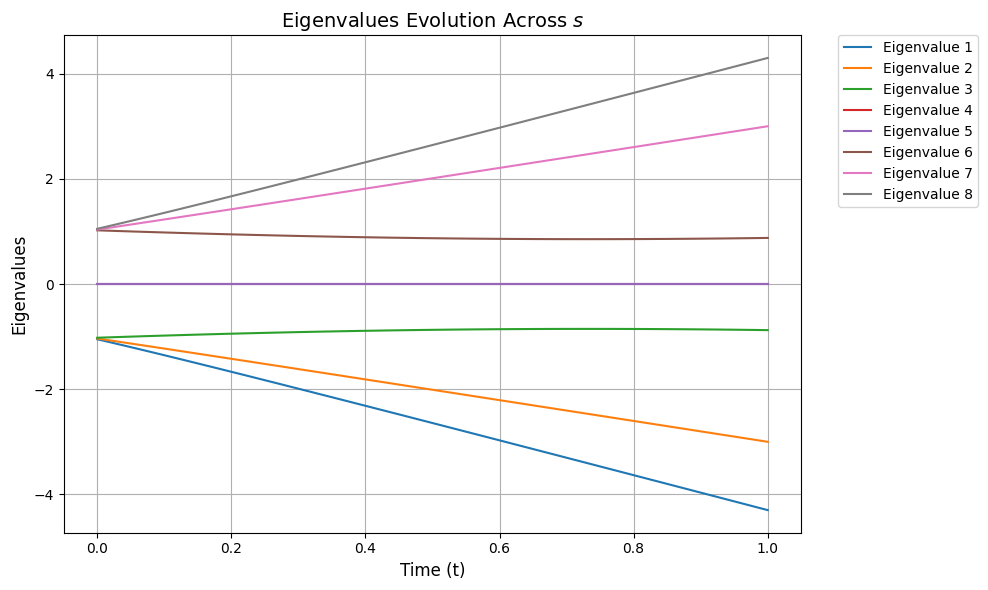

In [6]:
plot_eigenvalues_evolution()

To focus on the spectral gap from the null states, we can zoom in on our plot:

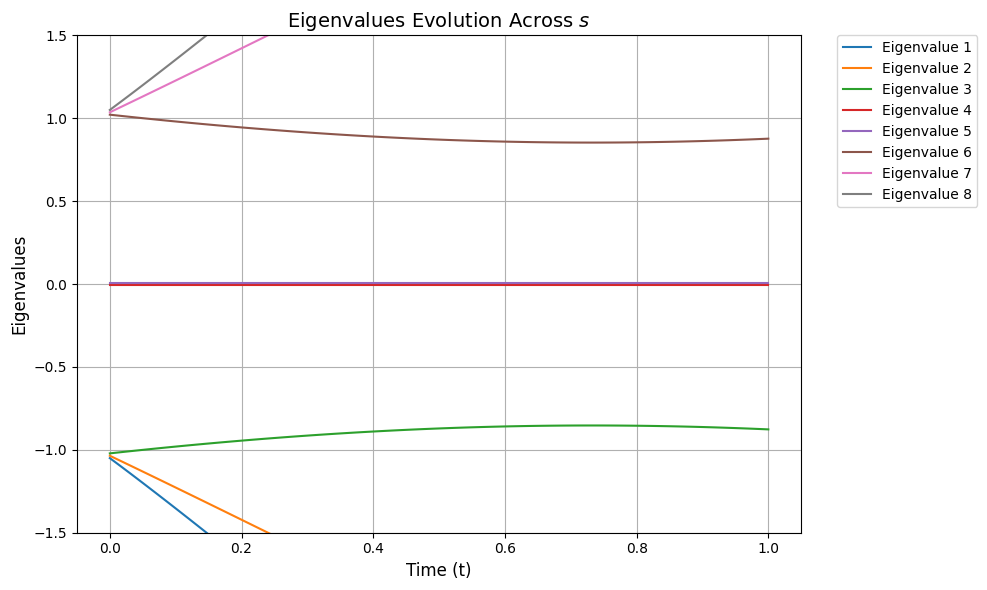

In [7]:
plot_eigenvalues_evolution(ylim=(-1.5, 1.5))

We can visually observe from the above that although the spectral gap does change throughout $s$ it still stays quite large in our example, so we can choose $T$ accordingly. Without going into detail we choose a simple value for $T$ (represented as `TOTAL_EVOLUTION_TIME`). However, if we simply assume $ \|H^{(1)}\|^2 $, $ \|H^{(2)}\|^2 $ are bounded by constants, and use the worst-case bound that $ \Delta \geq \kappa^{-1} $, it can be shown that to have $ \eta(1) \leq \epsilon $, the runtime of vanilla AQC is $ T \propto \kappa^3 / \epsilon $.


In [8]:
TOTAL_EVOLUTION_TIME = 7

------
### Implementing AQC


Since $$ |\psi_T(s) \rangle = \mathcal{T}\exp \left( -iT \int_0^s H(f(s')) ds' \right) |\psi_T(0) \rangle \ , $$ where $\mathcal{T}$ is the time-ordering operator, it is sufficient to implement an efficient time-dependent Hamiltonian simulation of $H(f(s))$.

One straightforward approach to achieve this is using the Trotter splitting method. The lowest order approximation takes the form

$$
\mathcal{T}\exp \left( -iT \int_0^s H(f(s')) ds' \right) \approx \prod_{m=1}^M \exp \left( -iTh H(f(s_m)) \right)
$$

which can further be approximated as

$$
\prod_{m=1}^M \exp \left( -iTh(1 - f(s_m)) H_0 \right) \exp \left( -iTh f(s_m) H_1 \right)
$$

where $$h = s/M,  s_m = mh.$$

It is proved in [[2](#WIM)] that the error of such an approximation is 

$$
\mathcal{O}(\text{poly}(\log(N)) \cdot T^2 / M),
$$

which indicates that to achieve an $ \epsilon$-approximation, it suffices to choose 

$$
M = \mathcal{O}(\text{poly}(\log(N)) \cdot T(\epsilon)^2 / \epsilon).
$$

(Note that in our case $T$ also depends on $\epsilon$.)


#### Building the Quantum Model

Using the Classiq platform, we implement the adiabatic path with Suzuki-Trotter decomposition for Hamiltonian exponentiation.

In our model $T$ is represented by the `TOTAL_EVOLUTION_TIME` and $M$ is represented by `NUM_STEPS`.


In the Trotter implementation, $M$ scales as $O(T^2)$ with respect to the runtime $T$, therefore this is our rough choice of $M$:

In [9]:
NUM_STEPS = 50


We are now ready to build our quantum model.

**The `adiabatic_evolution_qfunc` function implements the adiabatic path with Suzuki-Trotter decomposition for Hamiltonian exponentiation:** 

In [10]:
@qfunc
def adiabatic_evolution_qfunc(
    H0: CArray[PauliTerm],
    H1: CArray[PauliTerm],
    evolution_time: int,
    num_steps: int,
    qba: QArray,
):
    # Time step for each increment
    delta_t = evolution_time / num_steps
    for step in range(num_steps):
        t = step * delta_t
        suzuki_trotter(
            H0,
            evolution_coefficient=delta_t * (1 - t / evolution_time),
            order=1,
            repetitions=1,
            qbv=qba,
        )
        suzuki_trotter(
            H1,
            evolution_coefficient=delta_t * (t / evolution_time),
            order=1,
            repetitions=10,
            qbv=qba,
        )

To solve the QLSP we first prepare the $H_0$ zero state $|\tilde{b}\rangle$ and then initiate the evolution:


In [11]:
def get_model(H0, H1, b, evolution_time, num_steps):

    @qfunc
    def main(qba: Output[QArray]):
        prepare_state(
            probabilities=(np.abs(np.kron(np.array([1, 0]), b)) ** 2).tolist(),
            bound=0,
            out=qba,
        )
        adiabatic_evolution_qfunc(H0, H1, evolution_time, num_steps, qba)

    execution_preferences = ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )
    return create_model(main, execution_preferences=execution_preferences)


qmod_1 = get_model(
    HO_HAMILTONIAN, H1_HAMILTONIAN, b_normalized, TOTAL_EVOLUTION_TIME, NUM_STEPS
)

#### Synthesizing, Verifying, and Executing

Synthesize the model into a quantum program, verify it, and execute it on a state vector simulator:

In [12]:
qprog_1 = synthesize(qmod_1)
write_qmod(qmod_1, "solving_qlsp_with_aqc", decimal_precision=5, symbolic_only=False)
show(qprog_1)

result_1_state_vector = execute(qprog_1).result_value().state_vector

Quantum program link: https://platform.classiq.io/circuit/32paNlft3ZoQMzRuiu8FBiTDCnm


#### Evaluating the Results

In [13]:
def plot_state_probabilities(title, x, color="b"):
    # Ensure x is a numpy array and normalized
    x = np.array(x)

    # Calculate probabilities
    probabilities = np.abs(x) ** 2

    # Create labels for the states
    labels = [f"|{i}>" for i in range(len(x))]

    # Plot the probabilities
    plt.bar(labels, probabilities, color=color, alpha=0.7)
    plt.xlabel("States")
    plt.ylabel("Probabilities")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()


def compare_states(
    state1, state1_label, state2, state1_labe2, color1="gold", color2="b"
):
    # Plot a histogram of each state probabilities
    plot_state_probabilities(state1_label, state1, color1)
    plot_state_probabilities(state1_labe2, state2, color2)

    # Check the overlap between states
    overlap = np.abs(np.vdot(state1, state2)) ** 2
    print(f"Similarity of results: {overlap:.4f}")

Solution vector x:
[ 0.32300564 -0.23491319 -0.22423532  0.88893288]
State vector:
[-0.1344498 +0.27328988j  0.08719839-0.17724414j  0.13935271-0.28325579j
 -0.38067994+0.77379049j -0.12870338-0.06331791j  0.03060676+0.01505754j
  0.0128234 +0.0063087j   0.04876379+0.02399021j]


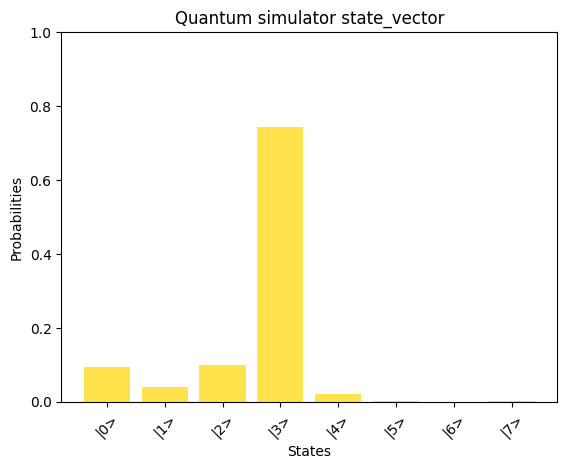

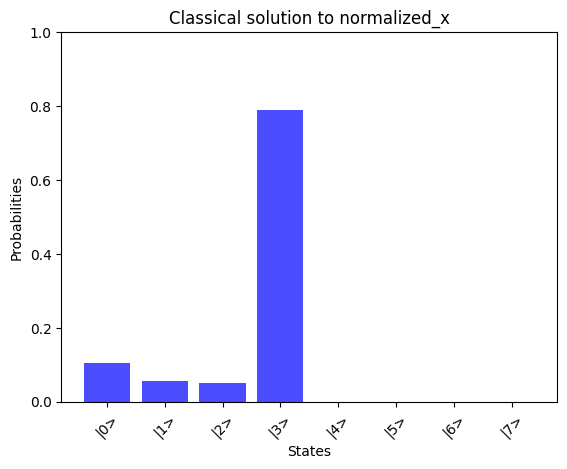

Similarity of results: 0.9646


In [14]:
# Print the solution vector x
x = np.linalg.solve(A_normalized, b_normalized)
print("Solution vector x:")
normalized_x = x / np.linalg.norm(x)
print(normalized_x)

# Convert dictionary values to complex numbers
print("State vector:")
state_vector = np.array([complex(value) for value in result_1_state_vector.values()])
print(state_vector)

compare_states(
    state_vector,
    "Quantum simulator state_vector",
    np.kron(np.array([1, 0]), normalized_x),
    "Classical solution to normalized_x",
)

**By comparing the quantum-computed results with the mathematically expected solution, we observe a good alignment, showcasing the potential of the AQC approach for solving linear problems.**



We can observe the runtime of the above implementation by analyzing the depth parameter from the transpiled circuit data of our quantum program:

In [15]:
print("Program depth:", qprog_1.transpiled_circuit.depth)

Program depth: 23488


For alternative QLSP configurations, it may be necessary to select different values for $T$ and $M$, and these choices will naturally impact the circuit depth. For instance:

In [16]:
# Define matrix A and vector b
A = np.array(
    [
        [3.9270525, 1.06841123, 2.09661281, -0.10400811],
        [1.06841123, 2.93584295, -0.0906049, 1.09754032],
        [2.09661281, -0.0906049, 2.87204449, 1.13774997],
        [-0.10400811, 1.09754032, 1.13774997, 1.85170585],
    ]
)
b = np.array([12, 10, 17, 26])

condition_number = compute_condition_number(A)
print("Condition number:", condition_number)

H0, H1, HO_HAMILTONIAN, H1_HAMILTONIAN, A_normalized, b_normalized = setup_QLSP(A, b)

Condition number: 5722470278.425136


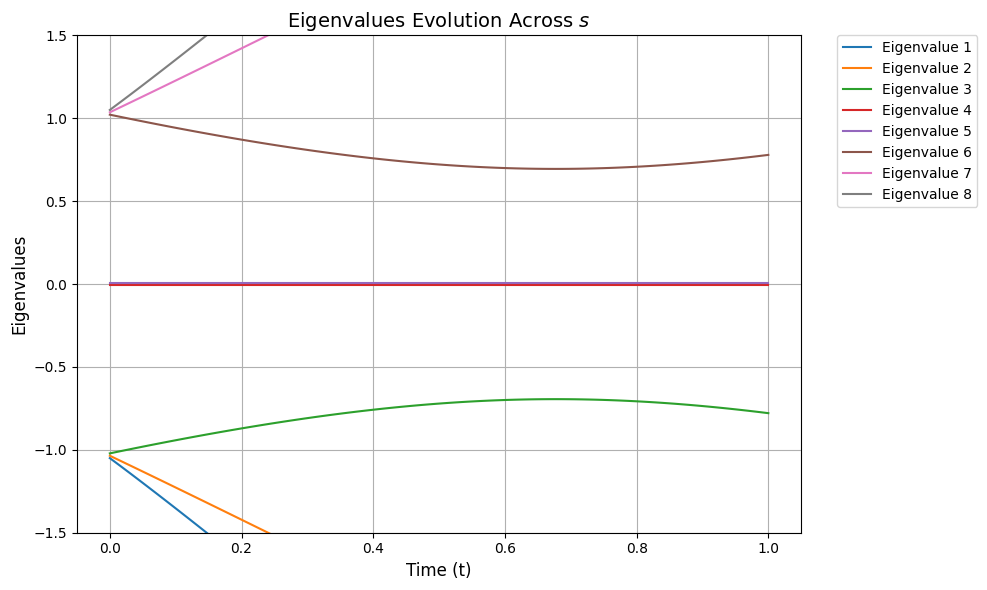

In [17]:
plot_eigenvalues_evolution(ylim=(-1.5, 1.5))

Although the condition number is higher, the spectral gap remains relatively large. However, using the same values of $T$ and $M$ as chosen above result in an increased error:

In [18]:
qmod_2 = get_model(
    HO_HAMILTONIAN, H1_HAMILTONIAN, b_normalized, TOTAL_EVOLUTION_TIME, NUM_STEPS
)
qprog_2 = synthesize(qmod_2)
show(qprog_2)
result_2_state_vector = execute(qprog_2).result_value().state_vector

Quantum program link: https://platform.classiq.io/circuit/32paYKGatGFV3MU1NEyHkU7B200


Solution vector x:
[ 0.42009163 -0.39396804 -0.55637591  0.59896415]
State vector:
[-0.22591226+0.29881383j  0.20964928-0.27730282j  0.40300266-0.53305108j
 -0.24070089+0.31837474j -0.22176295-0.16765947j  0.10465848+0.07912496j
  0.14898925+0.11264036j -0.0477411 -0.03609371j]


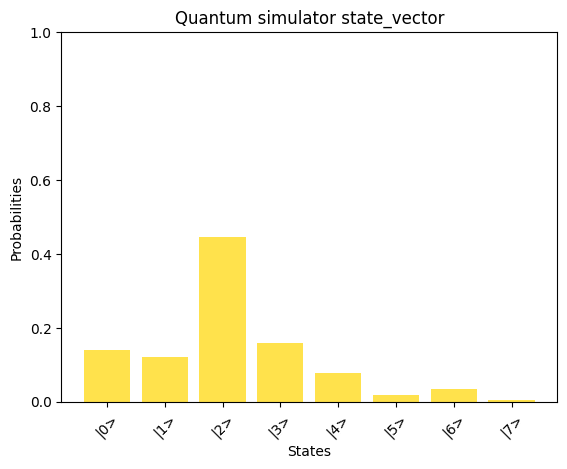

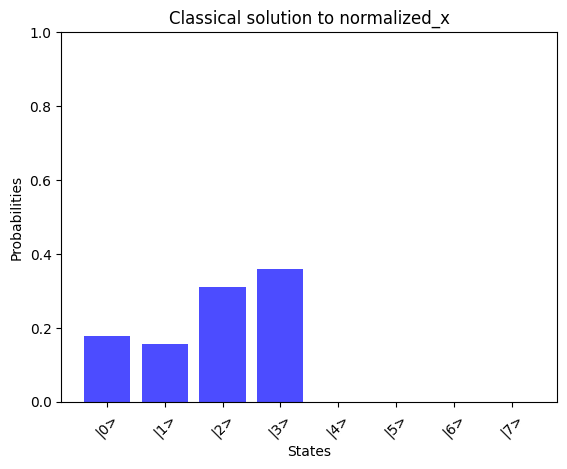

Similarity of results: 0.8194


In [19]:
# Print the solution vector x
x = np.linalg.solve(A_normalized, b_normalized)
print("Solution vector x:")
normalized_x = x / np.linalg.norm(x)
print(normalized_x)

# Convert dictionary values to complex numbers
print("State vector:")
state_vector = np.array([complex(value) for value in result_2_state_vector.values()])
print(state_vector)

compare_states(
    state_vector,
    "Quantum simulator state_vector",
    np.kron(np.array([1, 0]), normalized_x),
    "Classical solution to normalized_x",
)

In [20]:
print("Program depth:", qprog_2.transpiled_circuit.depth)

Program depth: 23438


Choosing $T$ and $M$ accordingly improves results but affects the overall runtime:

In [21]:
TOTAL_EVOLUTION_TIME = 10
NUM_STEPS = 100

In [22]:
qmod_3 = get_model(
    HO_HAMILTONIAN, H1_HAMILTONIAN, b_normalized, TOTAL_EVOLUTION_TIME, NUM_STEPS
)
qprog_3 = synthesize(qmod_3)
show(qprog_3)
result_3_state_vector = execute(qprog_3).result_value().state_vector

Quantum program link: https://platform.classiq.io/circuit/32pap71tIHx3qNNfMVnzjmEUzcU


Solution vector x:
[ 0.42009163 -0.39396804 -0.55637591  0.59896415]
State vector:
[ 0.48117857-0.16691207j -0.33080455+0.11475006j -0.49918647+0.17315868j
  0.51873488-0.17993967j  0.04227904+0.12188316j -0.01994299-0.05749218j
 -0.04130777-0.11908314j  0.01106469+0.03189757j]


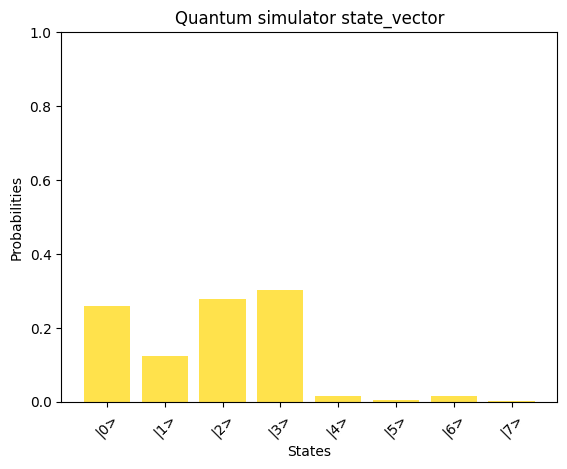

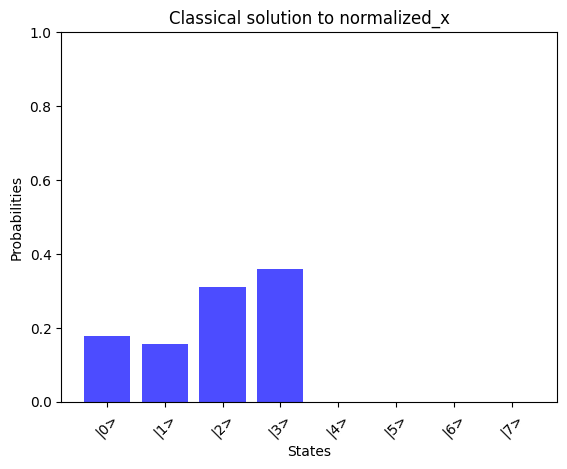

Similarity of results: 0.9501


In [23]:
# Print the solution vector x
x = np.linalg.solve(A_normalized, b_normalized)
print("Solution vector x:")
normalized_x = x / np.linalg.norm(x)
print(normalized_x)

# Convert dictionary values to complex numbers
print("State vector:")
state_vector = np.array([complex(value) for value in result_3_state_vector.values()])
print(state_vector)

compare_states(
    state_vector,
    "Quantum simulator state_vector",
    np.kron(np.array([1, 0]), normalized_x),
    "Classical solution to normalized_x",
)

In [24]:
print("Program depth:", qprog_3.transpiled_circuit.depth)

Program depth: 46088


As expected, the overall circuit depth increases to achieve a high degree of similarity in the results.

Although the results are satisfying, a more optimal approach can be implemented based on the discrete adiabatic theorem [[4](#DISCRETE)].

>***Important:*** The implementation example above aims to provide an intuitive understanding of the principles behind solving quantum linear solver problems with the adiabatic quantum evolution and the associated error bounds. However, for simplicity and accessibility, several aspects of the implementation are not optimal:  
>
>- **Suzuki-Trotter Decomposition**: We utilized the first order Suzuki-Trotter approximation for time evolution. As such (as mentioned above), a more optimal approach based on the discrete adiabatic theorem [[4](#DISCRETE)] could be implemented.   
>- **Schedule Function**: We used the vanilla AQC scheduling function. Using more sophisticated scheduling functions as suggested in [[1](#QLSP)] will improve runtime.  
>- **Brute-Force Encoding**: The encoding of Pauli operators in this tutorial is direct and unoptimized, scaling exponentially with system size. Other encoding techniques (such as suggested in [[4](#DISCRETE)]) will be more efficient. 
>
>These choices were made to prioritize conceptual clarity over computational efficiency. The next step would be to apply state-of-the-art techniques and show improvement in gate complexity and runtime.

### Appendix A: Explanation of the Adiabatic Error-bound Components

The adiabatic error bound $\eta(s)$ is defined by the quantum adiabatic theorem [[3](#ETA), Theorem 3]:

$$
\eta(s) = C \left\{
\frac{\|H^{(1)}(0)\|^2}{T \Delta^2(0)} + 
\frac{\|H^{(1)}(s)\|^2}{T \Delta^2(f(s))} +
\frac{1}{T} \int_0^s 
\left[ 
\frac{\|H^{(2)}(s')\|^2}{\Delta^2(f(s'))} + 
\frac{\|H^{(1)}(s')\|^2}{2\Delta^3(f(s'))}
\right] ds'
\right\}.
$$

Detailed explanation of components:

1. **$\eta(s)$**:
   - Represents the adiabatic error bound at a specific point $s \in [0, 1]$.
   - Quantifies the deviation of the quantum state from the ground state during evolution.

2. **$C$**:
   - A proportionality constant that depends on system-specific properties such as the dimensionality and scaling of norms.

3. **$\|H^{(1)}(0)\|$**:
   - The operator norm of the **first derivative** of the Hamiltonian, $H(s)$, evaluated at $s = 0$.
   - Indicates how quickly the Hamiltonian initially changes.

4. **$T$**:
   - The total runtime of the adiabatic evolution.
   - Larger $T$ values reduce the error, as slower evolution aids adiabaticity.

5. **$\Delta(0)$**:
   - The spectral gap at $s = 0$, defined as the energy difference between the ground state and the first excited state of $H(s)$.
   - Larger gaps improve the adiabatic process.

6. **$\|H^{(1)}(s)\|$**:
   - The operator norm of the first derivative of $H(s)$ at an intermediate point $s$.
   - Reflects how fast the Hamiltonian changes during evolution.

7. **$\Delta(f(s))$**:
   - The spectral gap at the point $s$, mapped via the function $f(s)$.

8. **$\|H^{(2)}(s')\|$**:
   - The operator norm of the **second derivative** of the Hamiltonian, $H^{(2)}(s')$, at a point $s'$.
   - Captures the curvature or acceleration of the Hamiltonian's evolution.

9. **$\int_0^s \cdots ds'$**:
   - An integral from $0$ to $s$, summing contributions of the Hamiltonian’s derivatives over the path.
   - Accounts for cumulative effects of the Hamiltonian's changes during evolution.

10. **$\Delta^2(f(s'))$** and **$\Delta^3(f(s'))$**:
    - Higher powers of the spectral gap at $s'$.
    - Larger gaps (in $\Delta^2$ and $\Delta^3$) significantly reduce the adiabatic error.



## References

<a id='QLSP'>[1]</a>: [An, D. and Lin, L. 2022. “Quantum Linear System Solver Based on Time-Optimal Adiabatic Quantum Computing and Quantum Approximate Optimization Algorithm.” ACM Trans. Quantum Comput. 3. arXiv:1909.05500](https://arxiv.org/abs/1909.05500)

<a id='WIM'>[2]</a>: [Wim van Dam, Michele Mosca, and Umesh Vazirani. 2001. How powerful is adiabatic quantum computation? In Proceedings 42nd IEEE Symposium on Foundations of Computer Science. IEEE, Piscataway, NJ, 279–287](https://arxiv.org/abs/quant-ph/0206003).

<a id='ETA'>[3]</a>: [Sabine Jansen, Mary-Beth Ruskai, and Ruedi Seiler. 2007. Bounds for the adiabatic approximation with applications to quantum computation. J. Math. Phys. 48, 10, 102111](https://arxiv.org/abs/quant-ph/0603175).


<a id='DISCRETE'>[4]</a>: [The discrete adiabatic quantum linear system solver has lower constant factors than the randomized adiabatic solver. 
Pedro C.S. Costa, Dong An, Ryan Babbush, Dominic Berry](https://arxiv.org/abs/2312.07690).